<a href="https://colab.research.google.com/github/valeria-molino/DataSciencePortfolio/blob/main/Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Dependencies & Transformation

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [ ]:
# Define image transformation
# Remember: since the prediction has to be determinisic, it's important avoid randomic factors in the test set (like horizontal flip)
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using sufficient statistics of ImageNet (of 3 channels) because of transfer learning
                         std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Custom Dataset

In [ ]:
class TumorDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.samples = []  # list of tuple (path_image, label)
    self.transform = transform

    # Map each class (Glioma, Meningioma, No Tumor, Pituitary) into a number (0, 1, 2, 3) with a dictionary
    classes = sorted(os.listdir(root_dir))
    self.class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

    # Construct the samples tuple using only the images and their subfolder
    # The result, for each image, is similar to ('Train/Glioma/images/img1.jpg', 0)
    for cls in classes:
      img_dir = os.path.join(root_dir, cls, "images")
      for img_name in os.listdir(img_dir):
        img_path = os.path.join(img_dir, img_name)
        self.samples.append((img_path, self.class_to_idx[cls]))

  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    img_path, label = self.samples[idx]
    img = Image.open(img_path).convert("RGB")
    if self.transform:
      img = self.transform(img)
    return img, label

Load Dataset

In [ ]:
import kagglehub

dataset_path = kagglehub.dataset_download("ahmedsorour1/mri-for-brain-tumor-with-bounding-boxes")
train_path = os.path.join(dataset_path, "Train")
test_path = os.path.join(dataset_path, "Val")

train_dataset = TumorDataset(train_path, transform=train_transforms)
test_dataset = TumorDataset(test_path, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Using Colab cache for faster access to the 'mri-for-brain-tumor-with-bounding-boxes' dataset.


In [ ]:
# Create the validation set like a part of the training test
from torch.utils.data import random_split

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(
    train_dataset,
    [train_size, val_size]
)

In [ ]:
original_dataset = train_dataset.dataset
class_names = [k for k, v in sorted(original_dataset.class_to_idx.items(), key=lambda item: item[1])]

Visualization

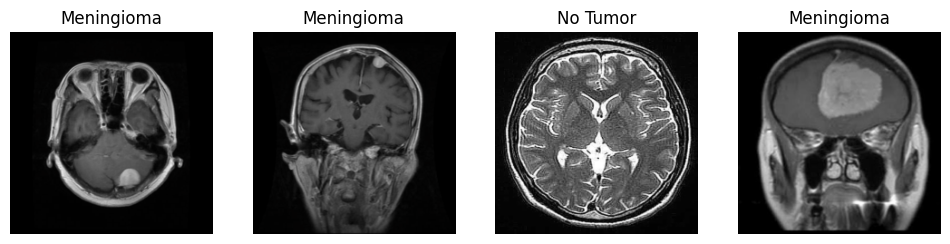

In [ ]:
import matplotlib.pyplot as plt
import torch

images, labels = next(iter(train_loader))

# Showing the first 4 image of a batch
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    img = images[i].permute(1, 2, 0)  # from [C,H,W] to [H,W,C] for matplotlib
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # denormalization
    img = img.clamp(0,1)  # only values between 0 and 1
    axes[i].imshow(img)
    axes[i].set_title(list(test_dataset.class_to_idx.keys())[labels[i]])
    axes[i].axis('off')
plt.show()

Load Pre-trained ResNet

In [ ]:
# Import dependencies
import torch
import torch.nn as nn
from torchvision import models

In [ ]:
model = models.resnet18(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Defreezing all convolutional layer and convert the last one Linear(in_features=512, out_features=1000, bias=True)
# into a 4 classes classifier
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)

print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Implementation of W&B

In [ ]:
import wandb
wandb.login()

wandb: Currently logged in as: valeria-molino (valeria-molino-projects) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
# Initialization of the project
wandb.init(
    project="Brain_Tumor_Classification",
    name="resnet18-transfer-learning",
    config={
        "architecture": "ResNet18",
        "dataset": "Brain MRI Tumor",
        "epochs": 100,
        "batch_size": 32,
        "learning_rate": 1e-3,
        "optimizer": "Adam"
    }
)

Implementation of Early Stopping method

In [ ]:
class EarlyStopping:
  def __init__(self, patience=5, verbose=False):
    self.patience = patience
    self.verbose = verbose
    self.counter = 0
    self.best_score = None
    self.early_stop = False

  # In each epoch evaluate the accuracy: if it improves reset counter and save the model
  def __call__(self, val_acc, model):
    score = val_acc

    if self.best_score is None:
      self.best_score = score
      torch.save(model.state_dict(), "best_model.pth")

    elif score <= self.best_score:
      self.counter += 1
      if self.verbose:
        print(f"No improvement. Patience: {self.counter}/{self.patience}")
      if self.counter >= self.patience:
        self.early_stop = True

    else:
      self.best_score = score
      torch.save(model.state_dict(), "best_model.pth")
      if self.verbose:
          print(f"Validation accuracy improved → model saved.")
      self.counter = 0

In [ ]:
early_stopper = EarlyStopping(patience=5, verbose=True)

Trainig Setup

In [ ]:
# Use Adam optimization and ReduceLROnPlateau as scheduler; it decreases of 50% if after 2 epochs there aren't improvements
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-3
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max', # maximize validation accuracy
    factor=0.5,
    patience=2
)

In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = model.to(device)

Using device: cuda


In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()

Training Loop

In [ ]:
num_epochs = 100

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Training
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        preds = outputs.argmax(dim=1)

        train_loss += loss.item() * images.size(0)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_loss /= train_total
    train_acc = train_correct / train_total

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            preds = outputs.argmax(dim=1)

            val_loss += loss.item() * images.size(0)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    # Log on W&B
    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "learning_rate": optimizer.param_groups[0]['lr']
    })

    print(f"  train_loss={train_loss:.4f}  train_acc={train_acc:.4f}")
    print(f"  val_loss={val_loss:.4f}      val_acc={val_acc:.4f}")
    print(f"  LR={optimizer.param_groups[0]['lr']:.6f}")

    # Scheduler
    scheduler.step(val_acc)

    # Early Stopping
    early_stopper(val_acc, model)

    if early_stopper.early_stop:
        print("Early stopping triggered. Training stopped.")
        break

print("Training finished.")


Epoch 1/100
  train_loss=1.2252  train_acc=0.4543
  val_loss=1.0903      val_acc=0.5508
  LR=0.000100
Epoch 2/100
  train_loss=0.9528  train_acc=0.6772
  val_loss=0.8962      val_acc=0.7012
  LR=0.000100
Validation accuracy improved → model saved.
Epoch 3/100
  train_loss=0.7977  train_acc=0.7522
  val_loss=0.7728      val_acc=0.7363
  LR=0.000100
Validation accuracy improved → model saved.
Epoch 4/100
  train_loss=0.7057  train_acc=0.7819
  val_loss=0.6914      val_acc=0.7812
  LR=0.000100
Validation accuracy improved → model saved.
Epoch 5/100
  train_loss=0.6399  train_acc=0.8020
  val_loss=0.6342      val_acc=0.7754
  LR=0.000100
No improvement. Patience: 1/5
Epoch 6/100
  train_loss=0.6009  train_acc=0.8117
  val_loss=0.5946      val_acc=0.7969
  LR=0.000100
Validation accuracy improved → model saved.
Epoch 7/100
  train_loss=0.5625  train_acc=0.8204
  val_loss=0.5635      val_acc=0.8008
  LR=0.000100
Validation accuracy improved → model saved.
Epoch 8/100
  train_loss=0.5389  tra

In [ ]:
# Load best model
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Testing phase

In [ ]:
# Test set and metrics
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import torch

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

Classification Report:
              precision    recall  f1-score   support

      Glioma       0.93      0.76      0.84       136
  Meningioma       0.74      0.81      0.77       140
    No Tumor       0.92      0.90      0.91       100
   Pituitary       0.86      0.95      0.90       136

    accuracy                           0.85       512
   macro avg       0.86      0.86      0.86       512
weighted avg       0.86      0.85      0.85       512



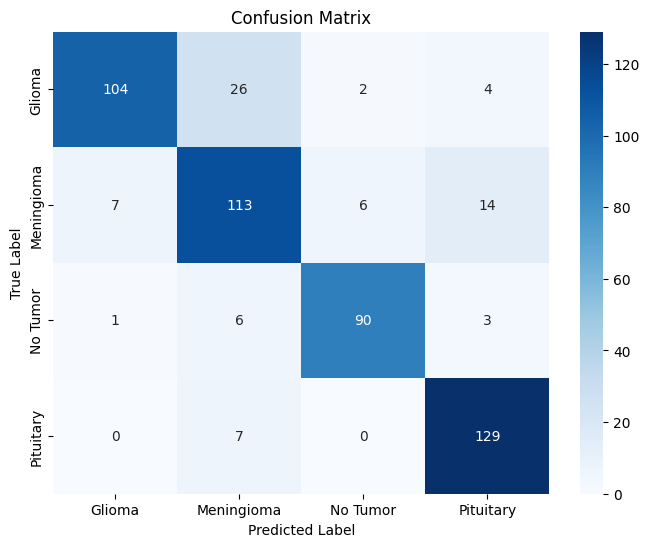

In [ ]:
# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")
plt.show()